In [1]:
#instalação de pacotes
!pip3 install pyramid-arima
!pip install pmdarima
!pip install mysql-connector-python

     |████████████████████████████████| 522kB 6.0MB/s 
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-v444nybm/pyramid-arima/setup.py'"'"'; __file__='"'"'/tmp/pip-install-v444nybm/pyramid-arima/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-c3se3p_y/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
     |████████████████████████████████| 1.5MB 5.2MB/s 
     |████████████████████████████████| 2.1MB 17.3MB/s 
     |████████████████████████████████| 9.5MB 26.8MB/s 
  Found existing installation: Cython 0.29.2

In [2]:
#from statsmodels.tsa.stattools import adfuller
#from numpy import log
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Importa dados

In [3]:
import numpy as np
import pandas as pd

#importa dados
data = pd.read_excel("python-time-series-local_files.xlsx")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DS_DATA_SEM_HORA  3522 non-null   object
 1   ISBN_PRODUTO      3522 non-null   int64 
 2   QTD_VENDA         3522 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 82.7+ KB


Prepara dados

In [4]:
#Filtra dados e remove colunas
df1 = data
df1['DS_DATA_SEM_HORA'] = pd.to_datetime(df1['DS_DATA_SEM_HORA'])
df1 = df1.rename(columns={"DS_DATA_SEM_HORA": "date", "QTD_VENDA": "value"})

cols = ['ISBN_PRODUTO']
df1.drop(cols, axis=1, inplace=True)

#transforma em time series
df1 = df1.sort_values('date')
df1 = df1.groupby('date')['value'].sum().reset_index()
df1 = df1.set_index('date')
df1 = df1['value'].resample('MS').sum()

In [5]:
#Separa dados
train = df1.loc[:'2018-12-31']
test = df1.loc['2019-01-01':]

# Analisa os dados

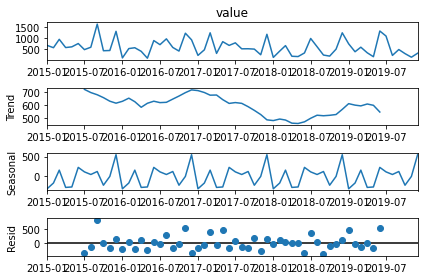

In [6]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt

a = seasonal_decompose(df1, model = "add")
a.plot();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


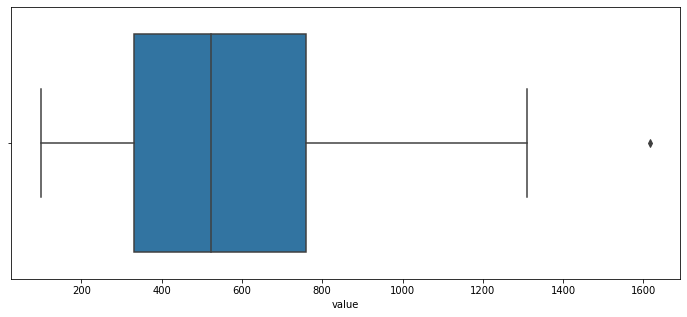

In [7]:
#Boxplot
import seaborn

fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(df1, ax=ax)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


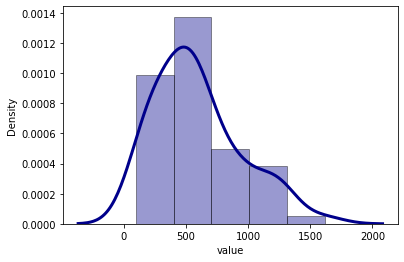

In [8]:
#Histograma
seaborn.distplot(df1, hist=True, kde=True, 
             bins=5, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3});

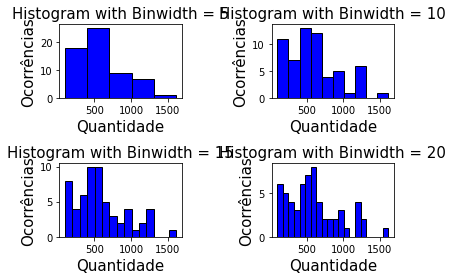

In [9]:
for i, binwidth in enumerate([5, 10, 15, 20]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df1, bins = binwidth, color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 15)
    ax.set_xlabel('Quantidade', size = 15)
    ax.set_ylabel('Ocorrências', size= 15)

plt.tight_layout()
plt.show()

# Modelos

Modelo Auto ARIMA

In [10]:
import pmdarima as pm

#Fit modelo auto-arima
fitSArima = pm.auto_arima(df1, start_p=1, start_q=1,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

#test='adf',

#fitSArima = pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4) 

fitSArima.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [11]:
#Teste 1
pm.auto_arima(df1, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
              d=None, D=1, trace=False,error_action='ignore',suppress_warnings=True,stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -350.089
Date:                  Sun, 28 Mar 2021   AIC                            706.177
Time:                          18:58:26   BIC                            711.791
Sample:                               0   HQIC                           708.299
                                   - 60                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -92.6416     58.553     -1.582      0.114    -207.404      22.121
ar.S.L12      -0.6316      0.114     -5.517      0.000      -0.856      -0.407
sigma2      1.159e+05   2.46e+04      4.722      0.000    6.78e+04    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.44   Prob(JB):                         0.77
Heteroskedasticity (H):               1.38   Skew:                             0.24
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Teste 2
#pm.auto_arima(df1, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

In [12]:
#Forecast auto-arima
n_periods = 12
predSArima, confint = fitSArima.predict(n_periods=n_periods, return_conf_int=True)

#Cria dataseries
predSArima = pd.DataFrame(predSArima,index = test.index,columns=['SARIMA'])

Modelo Prophet

In [13]:
#Dados Prophet
df2 = data

df2['DS_DATA_SEM_HORA'] = pd.to_datetime(df2['DS_DATA_SEM_HORA'])

df2['ds'] = df2['DS_DATA_SEM_HORA'].values.astype('datetime64[M]')

df2.drop(['DS_DATA_SEM_HORA','ISBN_PRODUTO'], axis=1, inplace=True)

df2 = data.rename(columns={"QTD_VENDA":"y"})

df2 = df2.groupby(['ds']).sum()

df2 = df2.reset_index()

In [14]:
from fbprophet import Prophet

#Fit modelo Prophet
fitProphet = Prophet()

fitProphet.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
#Forecast Prophet
future = fitProphet.make_future_dataframe(periods=12, freq='MS')

predProphet = fitProphet.predict(future)

predProphet1 = predProphet[['ds','yhat']]

predProphet1 = predProphet1.set_index('ds')
predProphet1 = predProphet1.rename(columns={"yhat": "PROPHET"})

predProphet1 = predProphet1['2019':'2019']

Modelo LSTM

In [17]:
#Dados LSTM

#importa dados
data = pd.read_excel("python-time-series-local_files.xlsx")

df3 = data

df3['DS_DATA_SEM_HORA'] = pd.to_datetime(df3['DS_DATA_SEM_HORA'])

df3['Mes'] = df3['DS_DATA_SEM_HORA'].values.astype('datetime64[M]')

df3.drop(['DS_DATA_SEM_HORA','ISBN_PRODUTO'], axis=1, inplace=True)

df3 = data.rename(columns={"QTD_VENDA":"Venda"})

df3 = df3.groupby(['Mes']).sum()

df3 = df3.reset_index()

df3 = df3.set_index("Mes")

df3.index.freq = 'MS'

train_data = df3[:len(df3)-12]
test_data = df3[len(df3)-12:]

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
nepochs=50
lstm_model.fit_generator(generator,epochs=nepochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
36/36 [==============================] - 2s 10ms/step - loss: 0.0775
Epoch 2/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0565
Epoch 3/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0581
Epoch 4/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0803
Epoch 5/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0544
Epoch 6/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0441
Epoch 7/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0441
Epoch 8/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0631
Epoch 9/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0471
Epoch 10/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 11/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0444
Epoch 12/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0652
Epoch 13/50
36/36 [======================

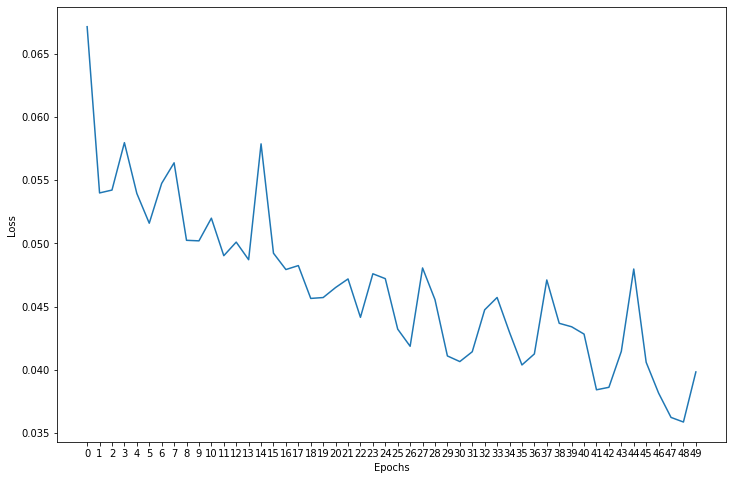

In [23]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,8))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,nepochs,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [24]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [25]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [26]:
test_data['LSTM'] = lstm_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Avaliação do Forecast

In [27]:
#Concatena predições
forecast = pd.concat([test,predSArima,predProphet1],axis=1)
forecast['LSTM'] = lstm_predictions

In [28]:
forecast

,value,SARIMA,PROPHET,LSTM
2019-01-01,739,84.349294,285.926413,363.164073
2019-02-01,387,343.332195,359.181222,475.831233
2019-03-01,589,928.598003,663.919202,638.406156
2019-04-01,341,160.035132,238.075210,487.642272
2019-05-01,166,503.979006,231.036632,497.470664
2019-06-01,1309,446.809573,703.431904,588.690274
2019-07-01,1085,737.201623,699.290478,749.236872
2019-08-01,224,437.587289,286.120694,554.902171
2019-09-01,485,316.114408,804.875573,455.774424
2019-10-01,304,289.797137,275.651965,499.123947


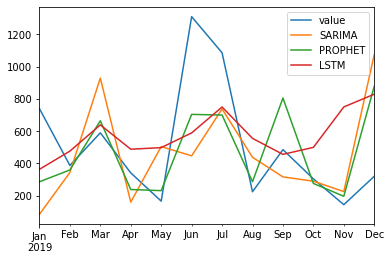

In [29]:
forecast.plot()

In [30]:
forecast['Ac_venda'] = test.cumsum()
forecast['Ac_SArima'] = forecast['SARIMA'].cumsum()
forecast['Ac_PROPHET'] = forecast['PROPHET'].cumsum()
forecast['Ac_LSTM'] = forecast['LSTM'].cumsum()

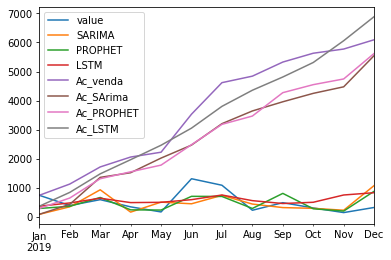

In [31]:
forecast.plot()

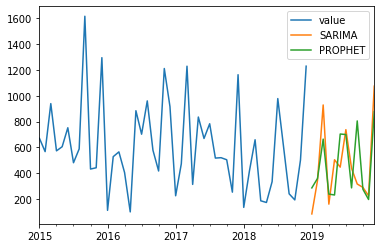

In [32]:
#Visão geral
pd.concat([train,predSArima,predProphet1],axis=1).plot()

Exporta Dados

In [33]:
forecast.to_excel ('forecast.xlsx', index = True, header=True, sheet_name = 'Dados')